# `aimmd.distributed.CommittorSimulation`
This notebook showcases how to steer a complete `CommittorSimulation` from python.

It assumes familiarity with the `GmxEngine`/`SlurmGmxEngine` and the `TrajectoryFunctionWrappers`, i.e. it is recommended to finish the notebooks `1_GmxEngine.ipynb` and `2_Conditional_trajectory_propagation_and_TrajectoryFunctionWrappers.ipynb`. As usual this notebook will only work if the gromacs executables are available.

### Imports and working directory

In [1]:
%%bash
# if using the module system to make gromacs and friends available:
# check that they are loaded!
#module list

In [2]:
%%bash
# unix only, check that gmx is available
which gmx

/usr/local/gromacs-2020.4/bin/gmx


In [3]:
%matplotlib inline

In [4]:
import os
import asyncio
import matplotlib.pyplot as plt
import numpy as np
import MDAnalysis as mda

In [5]:
import aimmd
import aimmd.distributed as aimmdd

Tensorflow/Keras not available


In [6]:
# setup working directory

#scratch_dir = "."
#scratch_dir = "/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/"
scratch_dir = "/home/think/scratch/aimmd_distributed/"

workdir = os.path.join(scratch_dir, "Committors_test")

if not os.path.isdir(workdir):
    os.mkdir(workdir)

### Setup logging
Note that this is entirely optional, i.e. you can skip the next 3 cells if you like. However for now we want the loglevel to be 'INFO' to see everything/most of the stuff that is done (and possibly goes wrong).

In [7]:
# setup logging
# executing this file sets the variable LOGCONFIG, which is a dictionary of logging presets 
%run ../resources/logconf.py

In [8]:
# have a look at the default logging level (the level used for the root logger)
print(LOGCONFIG["loggers"][""])
# have a look at the logger for aimmd
print(LOGCONFIG["loggers"]["aimmd"])
# and have a look at the log-level for the filehandler
print(LOGCONFIG["handlers"]["stdf"])
# the last two should both be `INFO`

{'level': 'WARN', 'handlers': ['stdf', 'warnout']}
{'level': 'INFO', 'handlers': ['stdf', 'warnout']}
{'class': 'logging.FileHandler', 'level': 'INFO', 'mode': 'w', 'filename': 'simulation.log', 'formatter': 'standardFormatter'}


In [9]:
# OPTIONAL: more logging
#LOGCONFIG["handlers"]["stdf"]["level"] = "DEBUG"
#LOGCONFIG["loggers"]["aimmd"]["level"] = "DEBUG"

In [10]:
# you can either modify single values or use it as is to get the same setup as in the OPS default logging config file
# you could e.g. do LOGCONF['handlers']['stdf']['filename'] = new_name to change the filename of the log
# the default is to create 'simulation.log' and 'initialization.log' in the current working directory
import logging.config
LOGCONFIG["handlers"]["stdf"]["filename"] = os.path.join(workdir, "simulation_committors.log")
LOGCONFIG["handlers"]["initf"]["filename"] = os.path.join(workdir, "initlog_committors.log")
logging.config.dictConfig(LOGCONFIG)

# `aimmd.distributed.CommittorSimulation` setup
The `CommittorSimulation` is a python class to steer/control multiple molecular simulations at the same time. It takes a list of starting configurations and the states to then propagate the trajectories (usually in chunks of walltime) until any of the states is reached. It supports oneway and twoway shooting (the later not beeing a true committor simulation because forward and backwards trajectories are correlated) and is the highlevel user-facing object to perform committor simulations.

To initialize and run a `CommittorSimulation` you need:
- `workdir`: The toplevel directory the simulation will run in
- `starting_configurations`: A list, every entry in the list corresponds to one configuration and must be an iterable itself, the single list entry structure is: `aimmd.distributed.Trajectory`, `index_of_conf_in_traj`, `name_for_configuration`; Note that the `name_for_configuration` is optional and will be used only as the name of the (sub)folder in which the trials for that configuration will be performed, if no name is supplied the folder will simply be named `configuration_$CONFNUM`
- `states`: A list of state functions, preferably wrapped using a `aimmd.distributed.TrajectoryFunctionWrapper`
- `engine_cls`: The class of the molecular dynamics engine to use, should be a sublcass of `aimmd.distributed.MDEngine`
- `engine_kwargs`: A dictionary with keyword arguments that can/will be used to instatiate the molecular dynamics engine
- `T`: float, the temperature to use when generating random Maxwell-Boltzmann velocities
- `walltime_per_part`: float, (maximum) walltime per trajectory segment in hours; Note that this does not determine the total length of the trajectories but only the size of the single trajectory segments
- `n_max_concurrent`: int, the maximum number of trials to propagate concurrently; Note for two way simulations you will run 2*`n_max_concurrent` molecular dynamic simulations in parallel
- `two_way`: wheter to run molecular dymaics forward and backward in time
- `max_steps`: int or None, the maximum number of integration steps to perform in total per trajectory, i.e. for two way simulations the combined maximum length of the resulting trajectory will be 2*`max_steps`

Note that you can set all attributes of the `CommittorSimulation` (`fname_traj_to_state`, `fname_transition_traj`, `deffnm_engine_out`, etc.) at initialization time by passing them as keyword arguments with the respective values you want to use.


Also Note, that the `CommittorSimulation` is quite flexible and allows the simulation of different physical ensembles for every starting configuration. This is achieved by allowing the parameters `engine_cls`, `engine_kwargs`, `T` and `twoway` to be either singletons (i.e. the same for the whole committor simulation) or a list with the same length as `starting_configurations` (i.e. one value per starting configuration). This means you can simulate systems differing in the number of molecules (by changing the topology used in the engine), at different pressures (by changing the molecular dynamics parameters passed with `engine_kwargs`), at different temperatures (by changing `T` and the parameters in the `engine_kwargs`) and even perform two way shots only for a selected subset of starting configurations (e.g. the ones you expect to be a transition state).

If the `CommittorSimulation` options still are not flexible enough for your needs you can always use the `TrajectoryPorpagatorUntilAnyState` (which is used under the hood anyway) to implement your own committor simulation from scratch.

In [11]:
# import state functions
from state_funcs_mda import alpha_R, C7_eq

# and wrapp them
wrapped_alphaR = aimmdd.PyTrajectoryFunctionWrapper(alpha_R)
wrapped_C7_eq = aimmdd.PyTrajectoryFunctionWrapper(C7_eq)

In [12]:
# Load the transition to take initial configurations from 
tp_traj = aimmdd.Trajectory(trajectory_file="gmx_infiles/TP_low_barrier_300K_amber99sbildn.trr",
                            structure_file="gmx_infiles/conf.gro")
print(f"The transition has a length of {len(tp_traj)} frames.")

The transition has a length of 102 frames.


In [13]:
# prepare a list of starting configurations
# we will take each frame of the transition once except the first and last frame (these are already inside the states)
# OPTIONAL: we will name each configuration 'frame$FRAMENUM_from_low_barrier_transition',
#           we could also just have used tuples of length 2: (traj, idx) and then every configuration would just get an index
starting_confs = [(tp_traj, i, f"frame{i}_from_low_barrier_transition") for i in range(1, len(tp_traj) - 1, 10)]
print(f"Selected {len(starting_confs)} frames as starting configurations.")

Selected 10 frames as starting configurations.


In [14]:
await wrapped_alphaR(tp_traj)

array([ True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [15]:
await wrapped_C7_eq(tp_traj)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True])

In [16]:
len(tp_traj)

102

In [17]:
# engine_kwargs
gro = "gmx_infiles/conf.gro"
top = "gmx_infiles/topol_amber99sbildn.top"
ndx = "gmx_infiles/index.ndx"
mdp = aimmdd.MDP("gmx_infiles/md.mdp")

print(f"The reference temperature ('ref-t') in the mdp file is: {mdp['ref-t']}.")

engine_kwargs = {"mdp": mdp, "gro_file":gro, "top_file":top, "ndx_file":ndx,
                 "mdrun_extra_args":"-nt 1",  # use this for GMX with (thread) MPI support
                 #"mdrun_extra_args": "-ntomp 2",  # and this for GMX sans (thread) MPI support
                 }

# here we simply use the `singleton` options for all configurations,
# i.e. all molecular dynamics simulations of this committor simulation sample the same ensemble
simulation = aimmdd.CommittorSimulation(workdir=workdir,
                                        starting_configurations=starting_confs,
                                        states=[wrapped_alphaR, wrapped_C7_eq],
                                        engine_cls=aimmdd.GmxEngine,
                                        engine_kwargs=engine_kwargs,
                                        T=mdp["ref-t"][0],
                                        #walltime_per_part=0.000015625,  # 0.055125 s per part
                                        walltime_per_part=0.000125,  # 0.45 s per part
                                        #walltime_per_part=0.005,  # run in simulation parts of 18 seconds 
                                        n_max_concurrent=10,  # start a maximum of 10 md engines engines (*2 if twoway!)
                                        ######################
                                        two_way=False,
                                        #########################
                                        max_retries_on_crash=5,  # maximum number of retries on crash, e.g. 5 means try at most 6 times
                                        )

The reference temperature ('ref-t') in the mdp file is: [300.0, 300.0].


In [18]:
# now run the simulation for 10 shots per configuration
ret = await simulation.run(10)
# the errors below stem from the fact that the transition contains 4 frames in alphaR (the state with index 0)
# therefore the TrajectoryPropagatorUntilAnyState raises an error and returns the starting configuration as a len 1 trajectory
# (the error is raised because usually something went wrong if the first frame already fulfills the stopping criteria)

(ERROR)aimmd.distributed.logic: Starting configuration (Trajectory(trajectory_file=/home/think/scratch/aimmd_distributed/Committors_test/frame1_from_low_barrier_transition/shot_0/start_conf_trial_fw.trr, structure_file=/home/think/Documents/sources/OPS/aimmd/examples/distributed/gmx_infiles/conf.gro)) is already inside the state with idx 0.
(ERROR)aimmd.distributed.logic: Starting configuration (Trajectory(trajectory_file=/home/think/scratch/aimmd_distributed/Committors_test/frame1_from_low_barrier_transition/shot_0/start_conf_trial_fw.trr, structure_file=/home/think/Documents/sources/OPS/aimmd/examples/distributed/gmx_infiles/conf.gro)) is already inside the state with idx 0.
(ERROR)aimmd.distributed.logic: Starting configuration (Trajectory(trajectory_file=/home/think/scratch/aimmd_distributed/Committors_test/frame1_from_low_barrier_transition/shot_1/start_conf_trial_fw.trr, structure_file=/home/think/Documents/sources/OPS/aimmd/examples/distributed/gmx_infiles/conf.gro)) is already 

# Have a look at and plot the results

In [19]:
import matplotlib

### Plot results for every starting configuration and shot seperately

Text(0, 0.5, 'State reached')

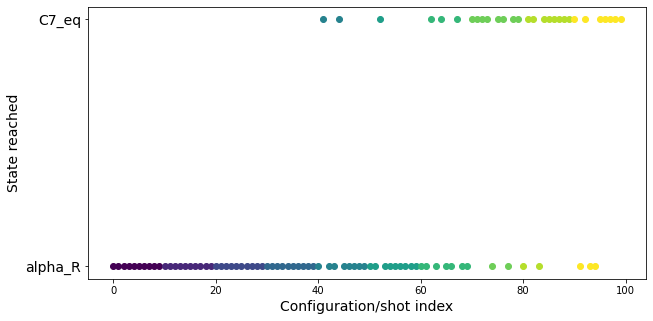

In [20]:
fig, axs = plt.subplots(figsize=(10, 5))

# ret are the shooting results per stucture and shot, i.e. it has shape = (n_conf, n_shot, n_states)
# it is the same as `CommittorSimulation.states_reached_per_shot`
n_conf, n_shot, n_states = simulation.states_reached_per_shot.shape
xses_per_conf = np.arange(0, n_shot)
# get a colorbar and a normalize instance to have different colors for starting structure
cmap = matplotlib.cm.get_cmap("viridis")
norm = matplotlib.colors.Normalize(vmin=0, vmax=n_conf-1)

for cnum, conf in enumerate(ret):
    # NOTE: this only works if ret is per configuration and per shot, i.e. if it can only have one True value (one 1) per array in the last axis
    plot_vals = np.full((n_shot,), np.nan)  # fill with the plot values
    idxs, state = np.where(conf)  # will return the idxs of the shot and idx of the state each shot reached
    plot_vals[idxs] = state
    axs.scatter(x=xses_per_conf + (n_shot * cnum),
                y=plot_vals,
                color=cmap(norm(cnum)),
                )

axs.set_yticks([i for i in range(n_states)])
axs.set_yticklabels(["alpha_R", "C7_eq"], size=14)
axs.set_xlabel("Configuration/shot index", size=14)
axs.set_ylabel("State reached", size=14)

### Plot committor estimates for every starting configuration, i.e. aggregated for every starting structure

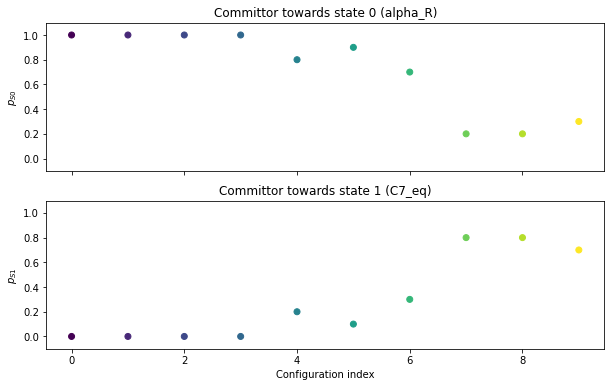

In [21]:
fig, axs = plt.subplots(figsize=(10,6), nrows=n_states, sharex=True)
# states_reached already aggregates the result for the same starting configuration
# it therefore has shape = (n_conf, n_states)
n_conf, n_states = simulation.states_reached.shape
for snum, (ax, name) in enumerate(zip(axs, ["alpha_R", "C7_eq"])):
    ax.set_title(f"Committor towards state {snum} ({name})")
    ax.scatter(x=np.arange(n_conf),
               y=simulation.states_reached[:, snum] / np.sum(simulation.states_reached, axis=1),
               c=cmap(norm(np.arange(n_conf))),
               )
    ax.set_ylim(-0.1, 1.1)
    ax.set_ylabel(f"$p_{{S{snum}}}$")
    if snum == 1:
        ax.set_xlabel("Configuration index")

# Add "backwards" shots to generate initial transitions
We will now add the conjugate "backwards" trials for the most promising configurations, i.e. thoose with shots that reached both states. To this end we will initialize a new committor simulation with only those configurations and use its `reinitialize_from_workdir()` method. We will set `twoway=True` to add the backwards shots for all of the configurations we now look at again. The `CommittorSimulation` will then add the missing backwards trials to all configurations it knows about. Note, that using a subset of the configurations only works since we named the configurations, if we had not done so we could still add the backwards shots, but would need to do so for all configurations (at least up to a given configuration number).

In addition to adding the missing backwards shots this will also write out any potentially generated transitions as one concatenated trajectory from the lower index state to the higher index state with the first and last frame in the states. Therfore the twoway shooting can be used to generate initial transitions for a subsequent transition path sampling simulation. Note however that this is usually only smart for configurations that have an roughly equal probability to reach both/multiple states, i.e. for potential transition states.

In [22]:
p_c7_eq = simulation.states_reached[:, 1] / np.sum(simulation.states_reached, axis=1)
confs_for_twoway = []
for sconf, p in zip(starting_confs, p_c7_eq):
    if 0.2 <= p <= 0.8:
        confs_for_twoway += [sconf]

        
print(f"Selected {len(confs_for_twoway)} promising configurations with p(TP|x) >= {round(2 * 0.25**2, 3)}.")

Selected 5 promising configurations with p(TP|x) >= 0.125.


In [23]:
new_simulation = aimmdd.CommittorSimulation(workdir=workdir,
                                            # take only a subset of the original starting configurations
                                            starting_configurations=confs_for_twoway,
                                            states=[wrapped_alphaR, wrapped_C7_eq],
                                            engine_cls=aimmdd.GmxEngine,
                                            engine_kwargs=engine_kwargs,
                                            T=mdp["ref-t"][0],
                                            #walltime_per_part=0.000015625,  # 0.055125 s per part
                                            walltime_per_part=0.000125,  # 0.45 s per part
                                            #walltime_per_part=0.005,  # run in simulation parts of 18 seconds 
                                            n_max_concurrent=4,  # start a maximum of 8 md engines engines (*2 because we use twoway=True)
                                            # NOTE: we changed twoway=True
                                            two_way=True,
                                            max_retries_on_crash=5,  # maximum number of retries on crash, e.g. 5 means try at most 6 times
                                           )

In [24]:
# NOTE: we need to allow overwriting of the existing traj_to_state for the forward shot by passing overwrite=True
#       otherwise the reinitialization will fail when it tries to rewrite the forward traj_to_state
#       (we could have also changed the filenames for the concatenated trajectory output)
ret = await new_simulation.reinitialize_from_workdir(overwrite=True)

# Accessing the generated trajectories
The concatenated trajectories until a state is reached and the potentially generated transition trajectories are all inside the respective `shot_$SHOTNUM` folders, however they can also be accessed from python via the properties `CommittorSimulation.trajs_to_state`, `CommittorSimulation.trajs_to_state_bw` and `CommittorSimulation.transitions`.

In [25]:
# show only the traj_to_state for first configuration this simulation knows about
new_simulation.trajs_to_state[0]

[Trajectory(trajectory_file=/home/think/scratch/aimmd_distributed/Committors_test/frame41_from_low_barrier_transition/shot_0/traj_to_state.trr, structure_file=/home/think/scratch/aimmd_distributed/Committors_test/frame41_from_low_barrier_transition/shot_0/trial_fw.tpr),
 Trajectory(trajectory_file=/home/think/scratch/aimmd_distributed/Committors_test/frame41_from_low_barrier_transition/shot_1/traj_to_state.trr, structure_file=/home/think/scratch/aimmd_distributed/Committors_test/frame41_from_low_barrier_transition/shot_1/trial_fw.tpr),
 Trajectory(trajectory_file=/home/think/scratch/aimmd_distributed/Committors_test/frame41_from_low_barrier_transition/shot_2/traj_to_state.trr, structure_file=/home/think/scratch/aimmd_distributed/Committors_test/frame41_from_low_barrier_transition/shot_2/trial_fw.tpr),
 Trajectory(trajectory_file=/home/think/scratch/aimmd_distributed/Committors_test/frame41_from_low_barrier_transition/shot_3/traj_to_state.trr, structure_file=/home/think/scratch/aimmd_di

In [26]:
# same here
new_simulation.trajs_to_state_bw[0]

[Trajectory(trajectory_file=/home/think/scratch/aimmd_distributed/Committors_test/frame41_from_low_barrier_transition/shot_0/traj_to_state_bw.trr, structure_file=/home/think/scratch/aimmd_distributed/Committors_test/frame41_from_low_barrier_transition/shot_0/trial_fw.tpr),
 Trajectory(trajectory_file=/home/think/scratch/aimmd_distributed/Committors_test/frame41_from_low_barrier_transition/shot_1/traj_to_state_bw.trr, structure_file=/home/think/scratch/aimmd_distributed/Committors_test/frame41_from_low_barrier_transition/shot_1/trial_fw.tpr),
 Trajectory(trajectory_file=/home/think/scratch/aimmd_distributed/Committors_test/frame41_from_low_barrier_transition/shot_2/traj_to_state_bw.trr, structure_file=/home/think/scratch/aimmd_distributed/Committors_test/frame41_from_low_barrier_transition/shot_2/trial_fw.tpr),
 Trajectory(trajectory_file=/home/think/scratch/aimmd_distributed/Committors_test/frame41_from_low_barrier_transition/shot_3/traj_to_state_bw.trr, structure_file=/home/think/scra

In [27]:
# and look at the first 2 configurations for the transitions to be sure there is one
new_simulation.transitions[:2]

[[Trajectory(trajectory_file=/home/think/scratch/aimmd_distributed/Committors_test/frame41_from_low_barrier_transition/shot_1/transition_traj.trr, structure_file=/home/think/scratch/aimmd_distributed/Committors_test/frame41_from_low_barrier_transition/shot_1/trial_fw.tpr),
  Trajectory(trajectory_file=/home/think/scratch/aimmd_distributed/Committors_test/frame41_from_low_barrier_transition/shot_4/transition_traj.trr, structure_file=/home/think/scratch/aimmd_distributed/Committors_test/frame41_from_low_barrier_transition/shot_4/trial_fw.tpr)],
 [Trajectory(trajectory_file=/home/think/scratch/aimmd_distributed/Committors_test/frame61_from_low_barrier_transition/shot_1/transition_traj.trr, structure_file=/home/think/scratch/aimmd_distributed/Committors_test/frame61_from_low_barrier_transition/shot_1/trial_fw.tpr),
  Trajectory(trajectory_file=/home/think/scratch/aimmd_distributed/Committors_test/frame61_from_low_barrier_transition/shot_2/transition_traj.trr, structure_file=/home/think/scr

# "Continuation" of the trials that reached only one state
This is a bit stupid, but just to showcase the possiblity to rerun a `CommittorSimulation` on an existing directory/run with possibly changed states. To this end, we will simply run the `CommittorSimulation` with only one state (the one we did not reach on the trials we rerun on). We will take the first few trials (started from configurations on the transition that are close(r) to alpha_R) as they should all/mostly have reached the alpha_R state and run a committor continuation with C7_eq as the only target state. This will result in continuing all choosen trial until they reach C7_eq (ignoring that they first reached alpha_R because the new `CommittorSimulation` does not know about alpha_R anymore).

In [28]:
# take the first 5 starting configurations for continuation, they will mostly have ended up in C7_eq
first_n_starting_configurations_to_take = 5

In [29]:
new_simulation2 = aimmdd.CommittorSimulation(workdir=workdir,
                                             # take only a subset of the original starting configurations
                                             # NOTE: we exclude the first frame because it is already inside alpha_R, i.e. we never
                                             #       started a trajectory for these shots, therefore the continuation will fail...
                                             starting_configurations=starting_confs[1:first_n_starting_configurations_to_take],
                                             states=[wrapped_C7_eq], # only C7_eq as target state
                                             engine_cls=aimmdd.GmxEngine,
                                             engine_kwargs=engine_kwargs,
                                             T=mdp["ref-t"][0],
                                             walltime_per_part=0.005,  # run in simulation parts of 18 seconds 
                                             n_max_concurrent=8,  # start a maximum of 8 md engines engines (*2 if twoway)
                                             max_retries_on_crash=5,  # maximum number of retries on crash, e.g. 5 means try at most 6 times
                                             # make sure we name the concatenated output trajs differently this time
                                             fname_traj_to_state="continuation_traj_to_state.trr",
                                             # not needed since we dont do twoway, but for completeness
                                             fname_traj_to_state_bw="continuation_traj_to_state_bw.trr",
                                             # not really needed, there can be no transitions with only one state anyway
                                             fname_transition_traj="transition_traj.trr",
                                            )

In [30]:
# since the concatenated output-trajs have different names we can pass overwrite=False (the default)
new_ret = await new_simulation2.reinitialize_from_workdir(overwrite=False)

In [31]:
new_ret

array([[[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]]])